In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image

from utils.evaluer import Evaluer
from utils.models import CNNEncoder, RNNDecoder
from utils.helpers import show_image, get_tokenizer_vocab, plot_attention

In [2]:
PATH = "dataset/"

In [3]:
df = pd.read_csv(PATH + "captions.txt")

In [4]:
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
tokenizer, vocab = get_tokenizer_vocab(df)

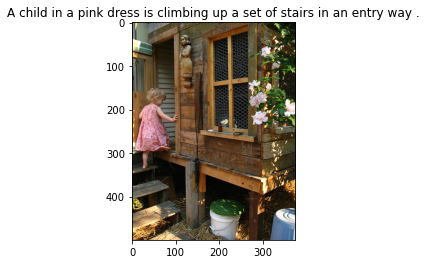

In [6]:
image = Image.open(PATH + "Images/" + df.image[0])
image_arr = np.asarray(image)
show_image(image_arr, df.caption[0])

In [7]:
encoder_dim, decoder_dim, attention_dim, embed_dim, vocab_size, max_len = 512, 256, 128, 64, len(vocab), 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
encoder = CNNEncoder(1536, encoder_dim)

In [9]:
decoder = RNNDecoder(encoder_dim=encoder_dim, 
                     decoder_dim=decoder_dim, 
                     attention_dim=attention_dim, 
                     embedding_dim=embed_dim, 
                     vocab_size=vocab_size
                    )

In [10]:
encoder.load_state_dict(torch.load("models/encoder.pt"))
encoder.eval()

decoder.load_state_dict(torch.load("models/decoder.pt"))
decoder.eval()

RNNDecoder(
  (embedding): Embedding(9213, 64)
  (gru): GRU(576, 256, batch_first=True)
  (fc_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=9213, bias=True)
  (attn): Attention(
    (encoder_attn): Linear(in_features=512, out_features=128, bias=False)
    (decoder_attn): Linear(in_features=256, out_features=128, bias=False)
    (value): Linear(in_features=128, out_features=1, bias=False)
    (softmax): Softmax(dim=1)
  )
  (softmax): Softmax(dim=1)
)

In [11]:
evaluer = Evaluer(encoder, decoder, vocab, 42, 64)

/Users/kad99kev/miniforge3/envs/py38/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [12]:
result, attention_plot = evaluer.evaluate(image)

/Users/kad99kev/miniforge3/envs/py38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
result

['two',
 'children',
 'are',
 'running',
 'of',
 'a',
 'city',
 'street',
 ',',
 'burning',
 'area',
 '.',
 '<eos>']

/Users/kad99kev/Desktop/Image-Captioning/utils/helpers.py:94: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(grid_size, grid_size, i + 1)


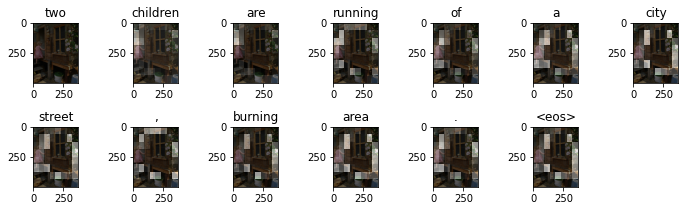

In [14]:
plot_attention(image, result, attention_plot)